In [1]:
import os
from torch import optim
from ignite.handlers import FastaiLRFinder
from ignite.engine import Events, create_supervised_trainer
from mevgs.train import (
    CONFIGS,
    UtilsTraining,
    identity_loss,
    setup_data,
    setup_model,
)

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [3]:
config = CONFIGS["22"]

In [4]:

device = config["device"]
model = setup_model(**config["model"])
model.to(device=device)

Using cache found in /home/doneata/.cache/torch/hub/facebookresearch_dino_main
/home/doneata/miniconda3/envs/mattnet/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/doneata/miniconda3/envs/mattnet/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


CLIP(
  (audio_enc): AudioEncoderTransformer(
    (layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (linear1): Linear(in_features=768, out_features=2048, bias=True)
         

In [5]:
# count model parameters
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(num_params(model.audio_enc))
print(num_params(model.image_enc))

12603648
3681280


In [6]:
optimizer = optim.Adam(model.parameters(), **config["optimizer"])

In [7]:
trainer = create_supervised_trainer(
    model,
    optimizer,
    prepare_batch=UtilsTraining.prepare_batch_fn,
    model_fn=UtilsTraining.model_fn,
    loss_fn=identity_loss,
    device=device,
)

In [8]:
def print_metrics(engine, tag):
    print("{:s} · {:4d} / {:4d} · loss: {:.3f}".format(
            tag,
            engine.state.epoch,
            engine.state.iteration,
            engine.state.output,
        )
    )

trainer.add_event_handler(
    Events.ITERATION_COMPLETED(every=1),
    print_metrics,
    tag="train",
)


In [9]:
config["data"]["batch_size"] = 48
dataloader_train, _ = setup_data(**config["data"])

2024-07-22 17:01:28,000 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<mevgs.data.PairedME': 
	{'num_workers': 16, 'batch_size': 48, 'collate_fn': <function collate_nested at 0x7ffac2a26950>, 'shuffle': True, 'pin_memory': True}
2024-07-22 17:01:28,002 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<mevgs.data.PairedME': 
	{'num_workers': 16, 'batch_size': 48, 'collate_fn': <function collate_nested at 0x7ffac2a26950>, 'pin_memory': True}


In [10]:
lr_finder = FastaiLRFinder()
to_save = {"optimizer": optimizer}

with lr_finder.attach(trainer, to_save=to_save, num_iter=256, start_lr=1e-8, end_lr=1e-2) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(dataloader_train)


train ·    1 /    1 · loss: 3.896
train ·    1 /    2 · loss: 2.537
train ·    1 /    3 · loss: 2.401
train ·    1 /    4 · loss: 2.848
train ·    1 /    5 · loss: 3.381
train ·    1 /    6 · loss: 2.557
train ·    1 /    7 · loss: 3.129
train ·    1 /    8 · loss: 2.841
train ·    1 /    9 · loss: 3.132
train ·    1 /   10 · loss: 2.774
train ·    1 /   11 · loss: 2.579
train ·    1 /   12 · loss: 2.665
train ·    1 /   13 · loss: 2.867
train ·    1 /   14 · loss: 2.858
train ·    1 /   15 · loss: 3.139
train ·    1 /   16 · loss: 2.897
train ·    1 /   17 · loss: 3.085
train ·    1 /   18 · loss: 3.542
train ·    1 /   19 · loss: 2.574
train ·    1 /   20 · loss: 3.030
train ·    1 /   21 · loss: 3.220
train ·    1 /   22 · loss: 3.419
train ·    1 /   23 · loss: 2.682
train ·    1 /   24 · loss: 2.656
train ·    1 /   25 · loss: 2.798
train ·    1 /   26 · loss: 2.590
train ·    1 /   27 · loss: 2.528
train ·    1 /   28 · loss: 2.933
train ·    1 /   29 · loss: 2.839
train ·    1 /

/home/doneata/miniconda3/envs/mattnet/lib/python3.10/site-packages/ignite/handlers/lr_finder.py:201: UserWarning: Run completed without loss diverging, increase end_lr, decrease diverge_th or look at lr_finder.plot()
  warnings.warn(


/home/doneata/miniconda3/envs/mattnet/lib/python3.10/site-packages/ignite/handlers/lr_finder.py:293: UserWarning: skip_start is larger than the suggested LR found and it will not be visible on the plot. Please, make the value smaller.
  warnings.warn(


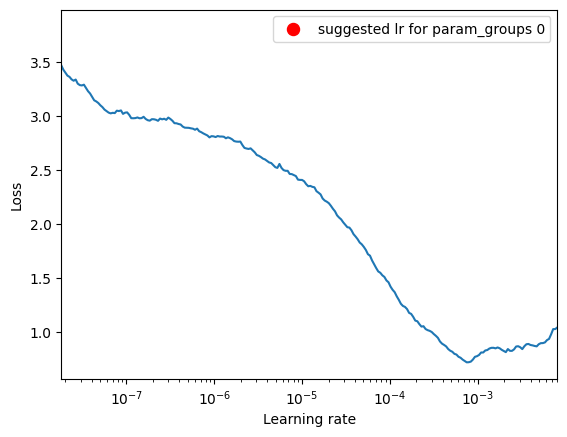

<Axes: xlabel='Learning rate', ylabel='Loss'>

In [11]:
# config: 22
lr_finder.plot()

/home/doneata/miniconda3/envs/mattnet/lib/python3.10/site-packages/ignite/handlers/lr_finder.py:293: UserWarning: skip_start is larger than the suggested LR found and it will not be visible on the plot. Please, make the value smaller.
  warnings.warn(


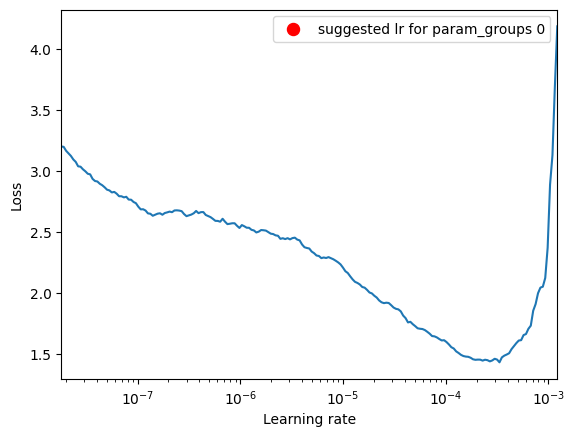

<Axes: xlabel='Learning rate', ylabel='Loss'>

In [10]:
# config: 20
lr_finder.plot()

/home/doneata/miniconda3/envs/mattnet/lib/python3.10/site-packages/ignite/handlers/lr_finder.py:293: UserWarning: skip_start is larger than the suggested LR found and it will not be visible on the plot. Please, make the value smaller.
  warnings.warn(


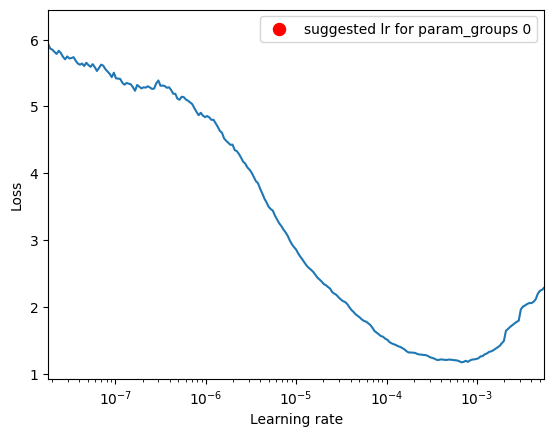

<Axes: xlabel='Learning rate', ylabel='Loss'>

In [11]:

lr_finder.plot()

In [12]:
lr_finder.lr_suggestion()

1.3823722273578995e-08